# 통계분석_1

In [ ]:
import pandas as pd
import numpy as np

# 빈도분석, 분포분석 (기초통계량 Set)

In [ ]:
df = pd.read_csv('data/titanic_simple.csv')

In [ ]:
df.shape

(891, 8)

In [ ]:
# type별로 컬럼 분류
col_id = ['PassengerId', 'Name']
col_cat = ['Survived', 'Pclass', 'Sex', 'Embarked']
col_num = ['Age', 'Fare']

In [ ]:
# dtypes 맞춰주는 중

#연속형
df[col_num] = df[col_num].astype('int', errors = 'ignore')

# 고윳값
df[col_id] = df[col_id].astype('str')

#범주형
for i in col_cat:
    df[i] = pd.Categorical(df[i])

In [ ]:
df.dtypes

PassengerId      object
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
Fare            float64
Embarked       category
dtype: object

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,Southhampton
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,Cherbourg
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,Southhampton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,Southhampton
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,Southhampton


## 기초통계량 Set

In [ ]:
# data에는 df[col_num]으로 연속형 변수만 선택된 데이터프레임이 들어가야 함
def DA(data):
    da = data.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    da = da.T
    df1 = data.isna().sum() # 결측값
    df1.name = 'missing'

    df2 = data.median() # 중앙값
    df2.name = 'median'

    df3 = np.var(data) # 분산
    df3.name = 'variance'

    df4 = data.skew() # 왜도 : 양수면 왼쪽으로 치우침
    df4.name = 'skewness'

    df5 = data.kurtosis() # 첨도 : 0보다 클수록 뾰족함
    df5.name = 'kurtosis'

    da = pd.concat([da,df1,df2,df3,df4,df5], axis=1) # 모두 합침

    da['total'] = da['count'] + da['missing'] # 전체 데이터 수

    # 컬럼 순서 보기 좋게 정렬
    col_nm = da.columns.tolist()
    order = [0, 14, 19, 1, 15, 2, 16, 17, 18]
    col_nm_new=[]
    for i in order:
        col_nm_new.append(col_nm[i])
    col_nm_new.extend(col_nm[3:14])
    da = da[col_nm_new]
    
    # 소수점 둘째자리 반올림
    da = da.round(2) 
    return da

DA1 = DA(df[col_num])
print('결측치 90% 이상 또는 데이터 발생이 90%부터인 데이터는 버리고')
DA1

결측치 90% 이상 또는 데이터 발생이 90%부터인 데이터는 버리고


,count,missing,total,mean,median,std,variance,skewness,kurtosis,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Age,714.0,177,891.0,29.7,28.00,14.53,210.72,0.39,0.18,0.42,1.0,4.00,14.00,20.12,28.00,38.0,50.00,56.00,65.87,80.00
Fare,891.0,0,891.0,32.2,14.45,49.69,2466.67,4.79,33.40,0.00,0.0,7.22,7.55,7.91,14.45,31.0,77.96,112.08,249.01,512.33


## 상관성 분석까지

In [ ]:
cor = df[col_num].corr()
cor2 = ((cor<1)&(cor>=0.7))|(cor<=-0.7)

sq = cor2.shape[0]
bu = []
for i in range(sq):
    for j in range(sq):
        if cor2.iloc[i,j] == True:
            bu.append(set([cor2.columns[i],cor2.index[j]]))

nb = []
for v in bu:
    if v not in nb:
        nb.append(v)

col_del = []
for w in nb:
    a = list(w)[0]
    b = list(w)[1]
    a_sup = DA1.loc[a,'count']
    b_sup = DA1.loc[b,'count']
    a_skew = DA1.loc[a,'skewness']
    b_skew = DA1.loc[b,'skewness']
    if a_sup>b_sup:
        col_del.appent(b)
    elif a_sup<b_sup:
        col_del.append(a)
    else:
        if a_skew>b_skew:
            col_del.append(a)
        else:
            col_del.append(b)
print(col_del)
print('이 컬럼들은 drop하시오.')


[]
이 컬럼들은 drop하시오.


# 분할표의 검정

## Fisher의 직접확률 검정
- 2 x 2 교차표에서 전체 데이터 숫자의 20%를 초과하는 Cell에서의 빈도가 5 미만이면 카이제곱테스트보다는 피셔의 정확성 검정을 하는 것이 좋다
- 5이상이어도 계산 가능하다

**예시**
- 대서양과 인도양에서 고래와 상어를 세는 데 며칠을 보낸다고 가정 해 보겠습니다. 대서양에서는 고래 8 마리와 상어 1 마리, 인도양에서는 고래 2 마리와 상어 5 마리가 있습니다. 그러면 우리의 분할 표는 다음과 같습니다.

In [ ]:
data = np.array([[8,2],[1,5]])
data = pd.DataFrame(data, columns=['Atlantic', 'Indian'])
data.index = ['whales','sharks']
data

,Atlantic,Indian
whales,8,2
sharks,1,5


In [ ]:
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data) # 교차표는 리스트, 배열, 데이터프레임 형식 모두 됨
pvalue

0.03496503496503495

**해석**
- 우연히 이것을 관찰하거나 훨씬 더 불균형 한 비율을 관찰 할 확률은 약 3.5 %입니다. 일반적으로 사용되는 유의 수준은 5 %입니다.이를 채택하면 관측 된 불균형이 통계적으로 유의하다는 결론을 내릴 수 있습니다. 고래는 대서양을 선호하고 상어는 인도양을 선호합니다.

## 맥네마의 검정
- **같은 샘플(paired)** 의 전후 상태를 교차표로 만들어 검정하는 것
- 상태는 1, 0 또는 good, bad처럼 명목형임

In [ ]:
data = pd.DataFrame([[40, 6],[2, 11]], columns=['After:Good', 'After:Bad'])
data.index = ['Before:Good','Before:Bad']
print('이런 데이터인데 실제 사용할 때는 데이터프레임은 사용 불가. 배열로 입력해야함')
data

이런 데이터인데 실제 사용할 때는 데이터프레임은 사용 불가. 배열로 입력해야함


,After:Good,After:Bad
Before:Good,40,6
Before:Bad,2,11


In [ ]:
data = np.array(data)
from statsmodels.stats.contingency_tables import mcnemar
# Cell 2 + Cell 3 샘플 사이즈가 25개 미만일 때
result = mcnemar(data, exact=True)

# Cell 2 + Cell 3 샘플 사이즈가 25개 이상일 때
# result = mcnemar([[8, 10],[17, 3]], exact=False, correction=True)

In [ ]:
print(result)

pvalue      0.2890624999999999
statistic   2.0


**해석**
- p-value가 0.05보다 크므로 귀무가설을 기각하지 않아, 전후 차이가 있다고 보기 어렵다.

# 상관분석
- 상관분석(Correlation Analysis)은 확률론과 통계학에서 두 변수간에 어떤 선형적 관계를 갖고 있는 지를 분석하는 방법입니다. 두변수는 서로 독립적인 관계로부터 서로 상관된 관계일 수 있으며 이때 두 변수간의 관계의 강도를 상관관계(Correlation, Correlation coefficient)라 합니다. 상관분석에서는 상관관계의 정도를 나타내는 단위로 모상관계수 ρ를 사용합니다.
- r 값은 x 와 y 가 완전히 동일하면 +1, 전혀 다르면 0, 반대방향으로 완전히 동일하면 -1 의 값을 갖습니다. 일반적으로 다음과 같이 해석합니다.
- 0.1 ~ 0.3:약한 상관관계 / 0.3 ~ 0.7: 뚜렷한 상관관계 / 0.7 ~ 1.0: 강한 상관관계

In [ ]:
data = pd.read_csv('data/kobe.csv')

## 상관계수

In [ ]:
data.corr()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
game_event_id,1.000000,0.009158,-0.010046,-0.036144,0.010046,-0.036144,-0.256954,0.960449,NaN,-0.038402,0.017654,-0.036044,NaN,0.033857
game_id,0.009158,1.000000,0.027316,0.013283,-0.027316,0.013283,-0.012726,-0.010312,NaN,0.013478,-0.037993,0.010778,NaN,0.850040
lat,-0.010046,0.027316,1.000000,-0.027813,-1.000000,-0.027813,0.056295,0.008438,NaN,0.068704,-0.805006,0.149569,NaN,0.059099
loc_x,-0.036144,0.013283,-0.027813,1.000000,0.027813,1.000000,0.032197,-0.028128,NaN,-0.038191,0.073700,0.019830,NaN,0.024730
loc_y,0.010046,-0.027316,-1.000000,0.027813,1.000000,0.027813,-0.056295,-0.008438,NaN,-0.068704,0.805006,-0.149569,NaN,-0.059099
lon,-0.036144,0.013283,-0.027813,1.000000,0.027813,1.000000,0.032197,-0.028128,NaN,-0.038191,0.073700,0.019830,NaN,0.024730
minutes_remaining,-0.256954,-0.012726,0.056295,0.032197,-0.056295,0.032197,1.000000,-0.019160,NaN,0.030857,-0.049937,0.025117,NaN,-0.028193
period,0.960449,-0.010312,0.008438,-0.028128,-0.008438,-0.028128,-0.019160,1.000000,NaN,-0.012597,0.004314,-0.029318,NaN,0.015836
playoffs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seconds_remaining,-0.038402,0.013478,0.068704,-0.038191,-0.068704,-0.038191,0.030857,-0.012597,NaN,1.000000,-0.050019,0.045542,NaN,0.003988


## 시각화 Heatmap

13.5 0.5


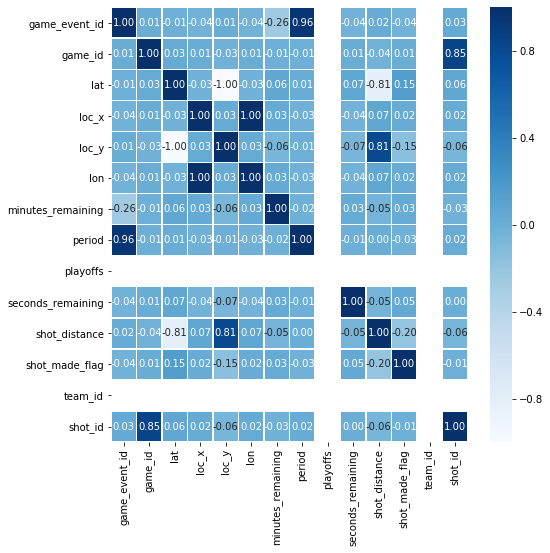

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data = data.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

# heatmap이 잘릴 대 아래 작성
buttom, top = ax.get_ylim()
print(buttom,top)
ax.set_ylim(buttom+0.5,top-0.5)

plt.show()

# 회귀분석

## 단순회귀분석
- 종속변수를 하나의 독립변수로 설명하는 것
- y ~ X1

In [ ]:
height = [170, 168, 177, 181 ,172, 171, 169, 175, 174, 178, 170, 167, 177, 182 ,173, 171, 170, 179, 175, 177, 186, 166, 183, 168]
weight = [70, 66, 73, 77, 74, 73, 69, 79, 77, 80, 74, 68, 71, 76, 78, 72, 68, 79, 77, 81, 84, 73, 78, 69]

body = pd.DataFrame(
    {'height': height,
    'weight': weight
    }
)
body.head(3)

,height,weight
0,170,70
1,168,66
2,177,73


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = body['weight'].values.reshape(-1,1) #단순회귀일 때는 reshape 필수
y = body['height']
model = LinearRegression()
model.fit(X, y)
print('R2 : ', model.score(X, y))

print('회귀계수 :',model.coef_)

print('절편 : ', model.intercept_)

R2 :  0.5893075473608536
회귀계수 : [0.89042657]
절편 :  107.86242266362746


In [ ]:
new = np.array([80, 70, 100]).reshape(-1,1) # predict할 때도 reshape 필수
model.predict(new)

array([179.09654836, 170.19228264, 196.90507978])

## 다중회귀분석
- X가 두 개 이상

### 교호작용을 고려하지 않을 때

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3

In [ ]:
X

array([[1, 1],
       [1, 2],
       [2, 2],
       [2, 3]])

In [ ]:
y

array([ 6,  8,  9, 11])

In [ ]:
model = LinearRegression().fit(X, y)
print('R2 : ', model.score(X, y))

print('회귀계수 :',model.coef_)

print('절편 : ', model.intercept_)

print(model.predict(np.array([[3, 5]])))

R2 :  1.0
회귀계수 : [1. 2.]
절편 :  3.0000000000000018
[16.]


### 교호작용을 고려할 때
- 교호작용이란 A의 효과가 B의 서로 다른 수준 B1과 B2에서 일관성 있게 나타난다면 두 인자 A, B 간에는 교호작용이 없다고 하고, 만일 B가 ‘B1수준에 있을 때 A의 효과’와 ‘B2수준에 있을 때 A의 효과’간에 차이가 있을 때, A, B 간에 교호작용이 존재한다고 합니다.
- X1, X2, X3가 있을 때 2차 교호작용 변수는 두 개 변수까지 곱하는 것, 3차는 세 개까지의 조합이겠지
- 제곱을 하는 것은 교호가 아니라 다항의 개념

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y =   1 * x_0     +     2 * x_1     + 3
y = np.dot(X, np.array([1, 2])) + 3

In [ ]:
y

array([ 6,  8,  9, 11])

In [ ]:
X

array([[1, 1],
       [1, 2],
       [2, 2],
       [2, 3]])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_d2 = PolynomialFeatures(degree=2, interaction_only=True)
# degree = 2 는 2차까지 만든다는 뜻, X3까지 있으면 degree=3도 가능할 듯
# interaction = True는 교호작용 변수만 만들고, 다항(제곱) 변수는 만들지 않겠다는 것
X_poly = poly_d2.fit_transform(X)
# 아래는 1, X1, X2, X1*X2 순
X_poly

array([[1., 1., 1., 1.],
       [1., 1., 2., 2.],
       [1., 2., 2., 4.],
       [1., 2., 3., 6.]])

In [ ]:
y

array([ 6,  8,  9, 11])

In [ ]:
model = LinearRegression().fit(X_poly, y)
print('R2 : ', model.score(X_poly, y))

print('회귀계수 :',model.coef_)

print('절편 : ', model.intercept_)

print(model.predict(np.array([[1, 3, 5, 15]])))

R2 :  1.0
회귀계수 : [ 0.00000000e+00  1.00000000e+00  2.00000000e+00 -1.55360188e-15]
절편 :  2.9999999999999956
[16.]


### 다중회귀분석 예시 : 집값 예측

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
#from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
# boston = load_boston()
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
bostonDF = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]),
                        columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
bostonDF['PRICE'] = raw_df.values[1::2, 2]

# boston 데이타셋 DataFrame 변환 
#bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
#bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


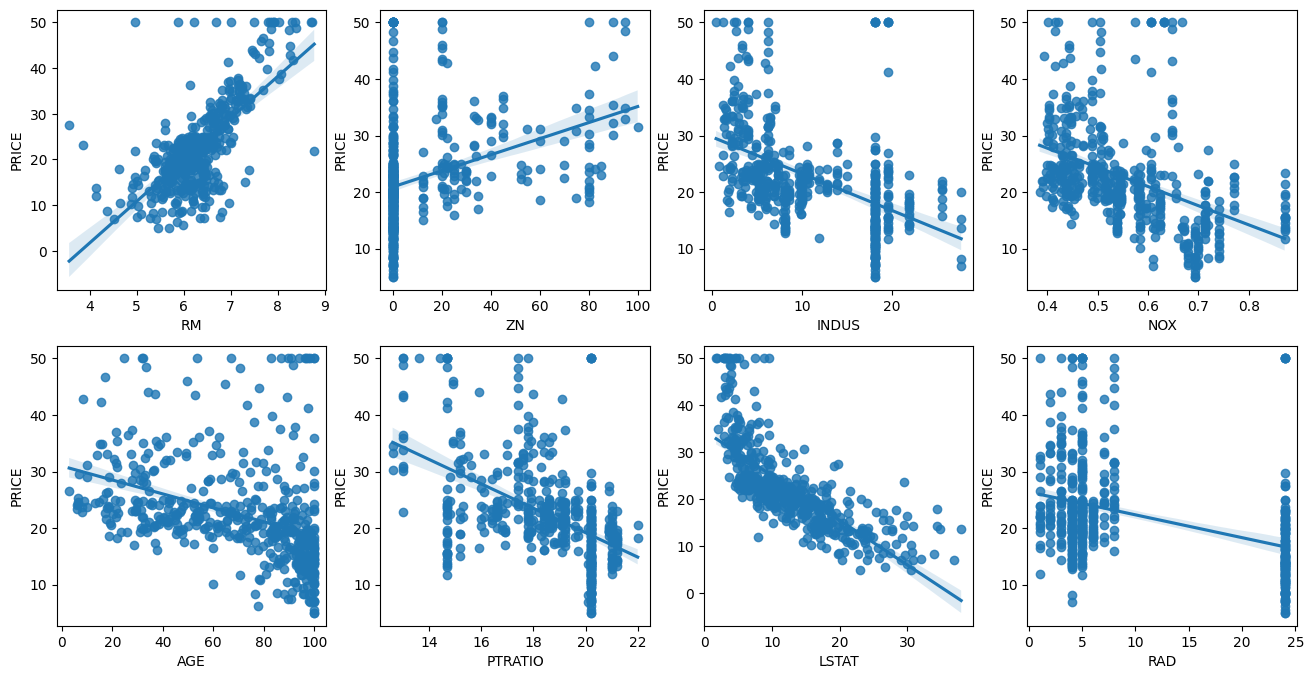

In [10]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [12]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [ ]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

#### Cross Validation 해보기
- 사이킷런 cross_val_score는 평가지표가 클수록 좋은 모델로 판단
- 회귀는 mse가 작을수록 좋은 모델이므로 평가지표를 neg_mean_squared_error로 사용

In [ ]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


## 다항회귀분석
- 종속변수와 독립변수의 관계가 선형이 아닐 때
- 차수가 높을수록 과적합

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def polynomial_func(X):
  y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
  return y

X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처:\n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

poly = PolynomialFeatures(degree=3) # degree는 몇 제곱까지할지 정하는 것
poly_ftr = poly.fit_transform(X)
print('3차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]
3차 다항식 계수 피처:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]


In [3]:
model = LinearRegression(fit_intercept=False)
model.fit(poly_ftr, y)
print('회귀계수 :', np.round(model.coef_, 2), ' 저차항부터 시작, 오른쪽 끝이 X^3')
print('R2 : ', model.score(poly_ftr, y))

회귀계수 : [0.58 0.15 0.73 0.3  0.45 1.18 0.6  0.89 1.34 2.51]  저차항부터 시작, 오른쪽 끝이 X^3
R2 :  1.0


In [7]:
from sklearn.pipeline import Pipeline

model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])
model = model.fit(X, y)

print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]



Degress 1 회귀 계수는 [-1.61]입니다.

Degress 1 MSE는 0.4077289625098685입니다.

Degress 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26]입니다.

Degress 4 MSE는 0.04320874987232064입니다.

Degress 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08]입니다.

Degress 15 MSE는 181238256.56423894입니다.


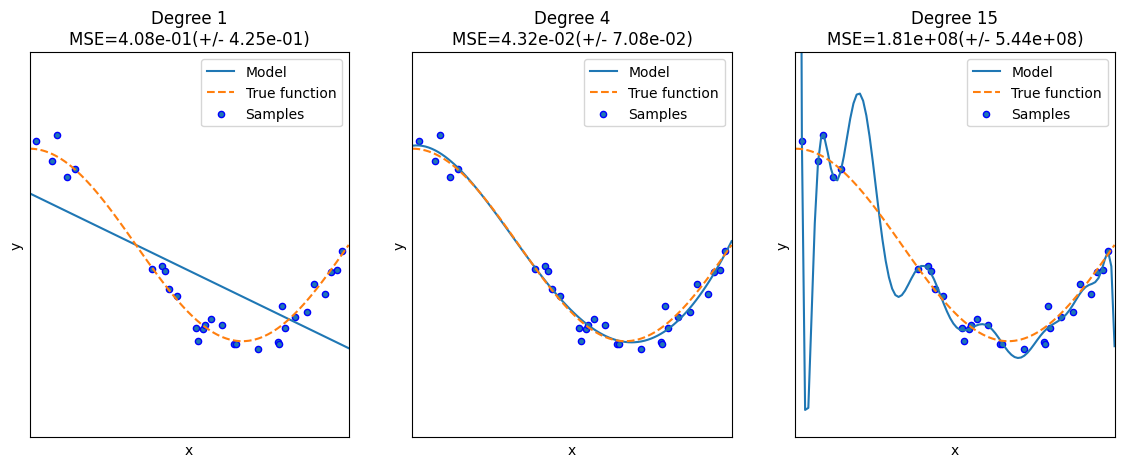

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환
def true_fun(X):
  return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14,5))
degrees = [1, 4, 15]
for i in range(len(degrees)):
  ax = plt.subplot(1, len(degrees), i+1)
  plt.setp(ax, xticks=(), yticks=())

  # 개별 degree별로 Polynomial 변환
  polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
  linear_regression = LinearRegression()
  pipeline = Pipeline([('Polynomial_fetures', polynomial_features),
                       ('linear_regression', linear_regression)])
  pipeline.fit(X.reshape(-1, 1), y)

  # 교차검증으로 다항회귀 평가
  scores = cross_val_score(pipeline, X.reshape(-1, 1), y, 
                           scoring='neg_mean_squared_error', cv=10)
  coefficients = pipeline.named_steps['linear_regression'].coef_
  print('\nDegress {0} 회귀 계수는 {1}입니다.'.format(degrees[i], np.round(coefficients,2)))
  print('\nDegress {0} MSE는 {1}입니다.'.format(degrees[i], -1*np.mean(scores)))

  X_test = np.linspace(0, 1, 100)
  plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label='Model')
  plt.plot(X_test, true_fun(X_test), '--', label='True function')
  plt.scatter(X, y, edgecolor='b', s=20, label='Samples')

  plt.xlabel('x');  plt.ylabel('y')
  plt.xlim((0,1));  plt.ylim((-2,2))
  plt.legend(loc='best')
  plt.title('Degree {}\nMSE={:.2e}(+/- {:.2e})'.format(degrees[i], -scores.mean(), scores.std()))

plt.show()

degree가 너무 작으면 과소적합, 크면 과적합되기 쉽다.  
degree 1은 고편향, degree 15는 고분산 특징을 가짐. 저편향, 저분산이 좋은 성능을 보여준다고 할 수 있다.  
편향과 분산은 서로 트레이드오프 관계이다.

### 규제를 통한 과적합 개선
- 비용함수에 규제 추가
- $min(RSS(w) + alpha ||w||^2_2)$
- alpha가 클수록 w가 작아지게 학습됨

#### Ridge - L2
- 회귀계수 W의 제곱에 페널티를 부과하는 것
- L2 규제

In [ ]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 Y_target 데이터셋을 그대로 이용 
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


- 기본 선형회귀보다 결과가 개선된 것을 알 수 있다. 

In [ ]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


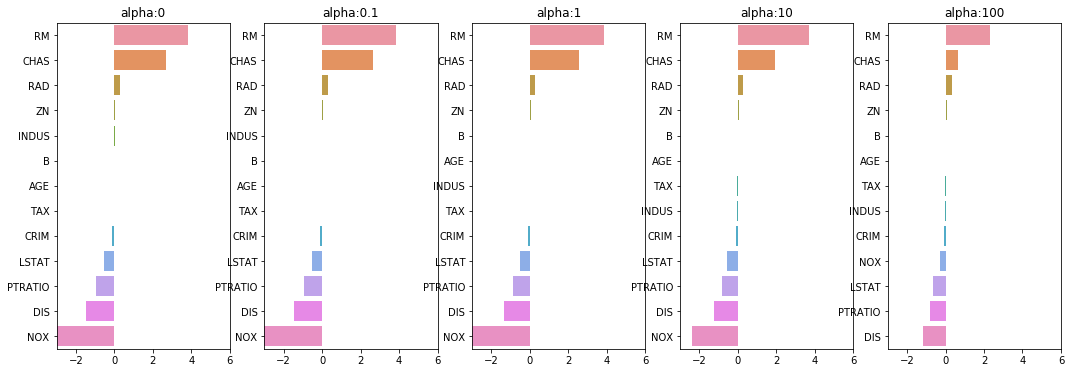

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()


alpha가 클수록 회귀계수가 작아지지만 회귀 계수가 0이 되지는 않는다.

In [ ]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


#### Lasso - L1
- 회귀계수 W의 절댓값에 페널티를 부과하는 것
- 영향력이 크지 않은 회귀계수를 0으로 변환하여 변수 선택 효과가 있음

In [10]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data_n , y_target_n)
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
        coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
# end of get_linear_regre_eval

In [14]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [ ]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


#### Elastic Net
- 릿지 라쏘의 규제를 결합한 회귀
- alpha값에 따라 회귀 계수의 값이 급격히 변동할 수 있는데 이를 완화하기 위해 L2 규제를 라쏘에 추가

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


## 트리 계열 회귀
- 비선형 회귀
- 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 소한 데이터 값의 평균값으로 회귀 예측값 계산
### Random Forest Regressor

In [15]:
#from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
# boston = load_boston()
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
bostonDF = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]),
                        columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
bostonDF['PRICE'] = raw_df.values[1::2, 2]

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

In [16]:
# 모델링
rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


### Decision Tree, Gradient Boosting, XGB, LGB

#### 여러 알고리즘 성능 한 번에 비교(아래에 하나씩 돌리는 거 따로 정리)

In [18]:
# 모델, X, y를 넣고 5 CV 평균 RMSE 계산하는 함수
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.251 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


#### Random Forest의 Feature Importance 시각화
- 회귀 계수 coef_ 함수가 없으므로 feature_importances_를 이용

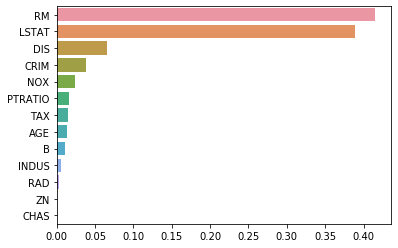

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

## 혼합모델(결과 더하는 거)
- 모델별 가중치는 기준이 있는 것은 아님
- 개별 모델 중에 성능 좋은 쪽에 약간 더 가중치를 주는 정도

In [ ]:
# 개별 모델 예측
# 릿지와 라쏘 섞어보기
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred

# XGB랑 LGB 섞어보기
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred

# Feature selection


- 데이터 로딩

In [ ]:
X = data.drop(['Outcome'], axis=1)
Y = data['Outcome']

## VarianceThreshold
- 분산은 각 변수의 스케일에 따라 값이 작거나 커질 수 있으니 주의.
- threshold=0으로 하면, 모든 값이 같은 변수가 제거될 것임

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.2)
X_reduced = selector.fit_transform(X)

In [ ]:
print(X.shape)
print(X_reduced.shape)

In [ ]:
# 어떤 변수가 없어졌는지는 몇줄 비교해보면 알 수 있음
print(X.head(2))
print(60 * '=')
print(X_reduced[0:2, :])

## Chi-squared based feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k='all')
#selector = SelectKBest(chi2, k=5)로 하면 5개만 뽑힘
X_reduced = selector.fit_transform(X, Y)

In [ ]:
print(X.shape)
print(X_reduced.shape)

In [ ]:
print(X.head(2))
print(60 * '=')
print(X_reduced[0:2, :])

In [ ]:
print(selector.scores_)
print(selector.pvalues_)

## Recursive feature elimination (RFE)
- scikit-learn에서 제공하는 wrapper 방식의 feature selection
- 일종의 Backward elimination과 유사함(feature를 줄여나가는 것)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [ ]:
svc = SVC(kernel='linear')
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=1)
rfecv.fit(X, Y)

In [ ]:
print(rfecv.n_features_)
print(rfecv.support_)

In [ ]:
X.columns

## Selecting features by model
- Attribute에 **coef_** 또는 **feature_importances**가 있는 estimator만 사용 가능함: Lasso, LogisticRegression, LinearSVC, Tree계열 모델들

### L1-regularized model

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.05)
lr.fit(X, Y)

In [ ]:
lr.coef_

In [ ]:
selector = SelectFromModel(estimator=lr, threshold=0.000001, prefit=True)
# 위에서 select 되지 않은 것들은 쳐냄. threshold를 아주 작게 줘서 이거보다 작으면 제거
X_reduced = selector.transform(X)

In [ ]:
print(X.shape)
print(X_reduced.shape)

In [ ]:
print(X.head(2))
print(60 * '=')
print(X_reduced[0:2, :])

### Tree model

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, max_features='auto')
rf.fit(X, Y)

In [ ]:
rf.feature_importances_

In [ ]:
selector = SelectFromModel(estimator=rf, threshold=0.1, prefit=True)
X_reduced = selector.transform(X)

In [ ]:
print(X.shape)
print(X_reduced.shape)

In [ ]:
print(X.head(2))
print(60 * '=')
print(X_reduced[0:2, :])